<a href="https://colab.research.google.com/github/Small-Fiend/CUDA_Laboratory/blob/main/Bilateral%20Filtering/Bilateral_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from PIL import Image
from google.colab import files
from io import BytesIO
import pandas as pd
import numpy as np
from time import time
from numba import njit, jit, int32, cuda

Загружаем необходимое изображение

Saving 26934081.jpg to 26934081 (2).jpg


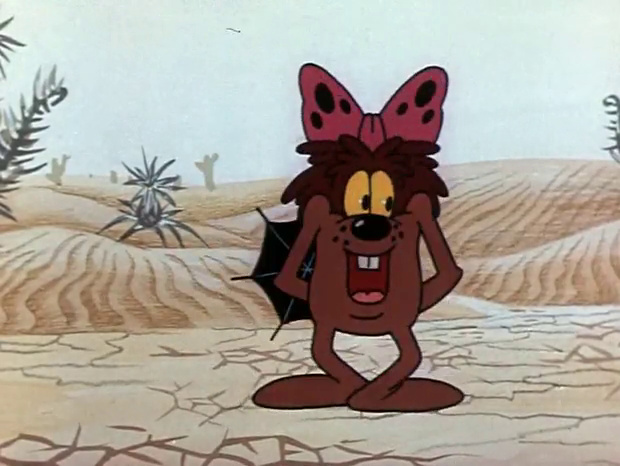

In [39]:
uploaded = files.upload()
img = Image.open(BytesIO(uploaded['26934081.jpg']))
img

Функция двустороннего фильтра на CPU (bilateralFilter)

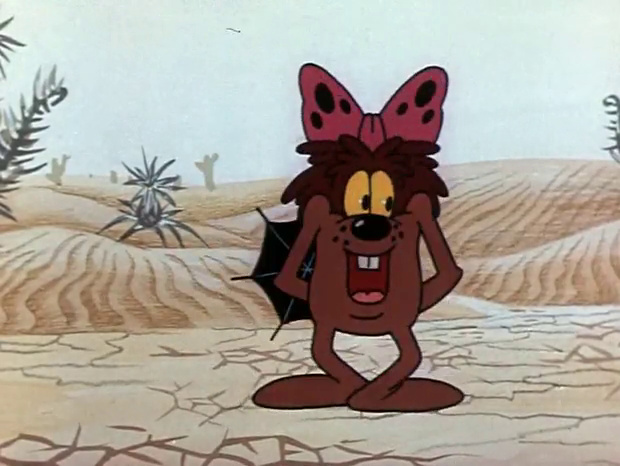

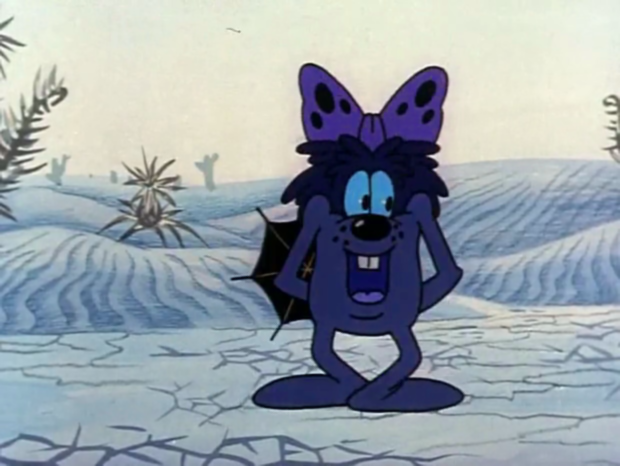

time CPU original image:  0:00:00.148888


True

In [70]:
image = cv2.imread('26934081.jpg')
display(Image.fromarray(np.uint8(img)))

# Стартовое время
start_time = datetime.datetime.now()

# По условию необходимо использовать 9 точек, следовательно d=1, т.к. у кадого пикселя 8 соседей
bilateral_blur = cv2.bilateralFilter(image,1,1000,1000)
display(Image.fromarray(np.uint8(bilateral_blur)))

# Затраченное время
time_CPU = datetime.datetime.now() - start_time
print ('time CPU original image:  '+ str(time_CPU))
cv2.imwrite('bilateral_CPU.jpg', bilateral_blur)

Аналогично для изображения в градациях серого

Исходное изображение


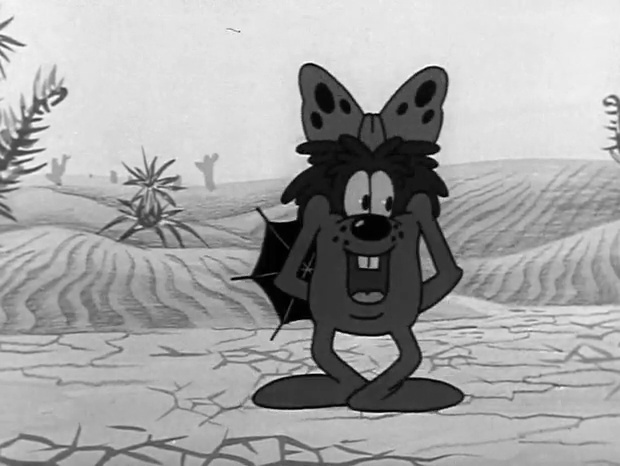

Исходное изображение


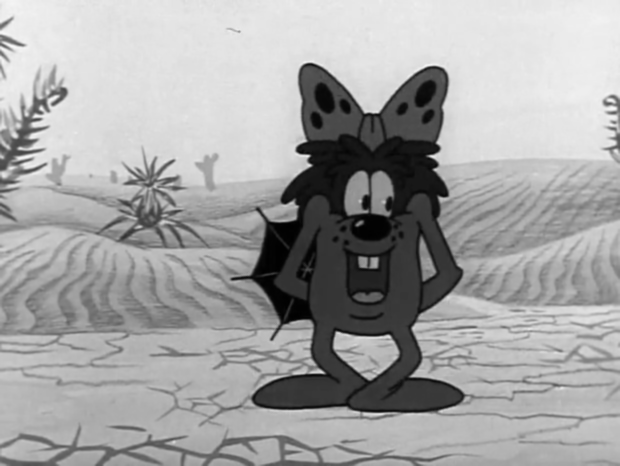

time CPU gray image:  0:00:00.056892


In [73]:
img_gray= cv2.imread('26934081.jpg', cv2.IMREAD_GRAYSCALE)
img_gray.shape
print("Исходное изображение")
display(Image.fromarray(np.uint8(img_gray)))

# Стартовое время
start_time = datetime.datetime.now()

bilateral_blur_gray = cv2.bilateralFilter(img_gray,1,1000,1000)
print("Исходное изображение")
display(Image.fromarray(np.uint8(bilateral_blur_gray)))

# Затраченное время
time_CPU_gray = datetime.datetime.now() - start_time
print ('time CPU gray image:  '+ str(time_CPU_gray))

Функция двусторонней фильтрации на GPU

In [44]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 66 kB 4.2 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626633 sha256=a6e9ebcee1d9193d25d58ee4caffd61567cef7eb1b40b7baf3bce8b856758f0b
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=b593747ca22e95a2c758ccf8d02282a29210c972a1682c178f97bbe0902b35fb
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


In [45]:
from pycuda import driver, compiler
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [46]:
# texture memory

BilateralGPU = SourceModule("""
texture<unsigned int, 2, cudaReadModeElementType> tex;
__global__ void BilateralGPU(unsigned int* result, const int M, const int N, const float sigma_d, const float sigma_r){
  
  const int i = threadIdx.x + blockDim.x * blockIdx.x;
  const int j = threadIdx.y + blockDim.y * blockIdx.y;
  
  if ((i < M) && (j < N)) {
    float s = 0;
    float c = 0;
    
    for (int l = i - 1; l <= i + 1; l++){
      for (int k = j - 1; k <= j + 1; k++){
        float f1 = tex2D(tex, k, l) / 255;
        float f2 = tex2D(tex, i, j) / 255;
        float g = exp(-(pow(k - i, 2) + pow(l - j, 2)) / pow(sigma_d, 2));
        float r = exp(-pow((f1 - f2) * 255, 2) / pow(sigma_r, 2));
        c += g * r;
        s += g * r * tex2D(tex, k, l);
      }
    }
    result[i * N + j] = s / c;
  }
}
""")

BilateralFilteringGPU = BilateralGPU.get_function("BilateralGPU")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).



Загружаем изображение в градациях серого

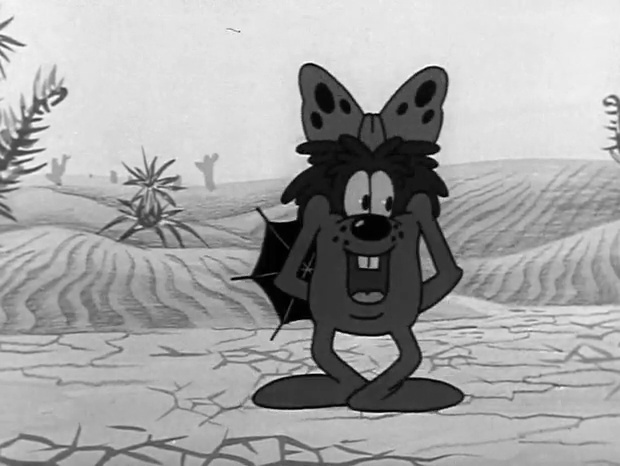

In [49]:
img_gray= cv2.imread('26934081.jpg', cv2.IMREAD_GRAYSCALE)
img_gray.shape
display(Image.fromarray(np.uint8(img_gray)))

In [51]:
M = img_gray.shape[0]
N = img_gray.shape[1]
block = (16, 16, 1)

grid = (int(np.ceil(M/block[0])),int(np.ceil(N/block[1])))

In [61]:
#Значения BilateralFilteringGPU
sigma_сolor = 1000
sigma_space = 1000

Исходное изображение


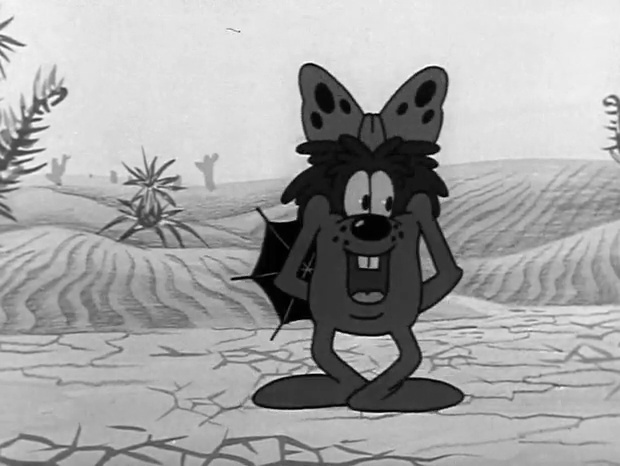

Полученное изображение


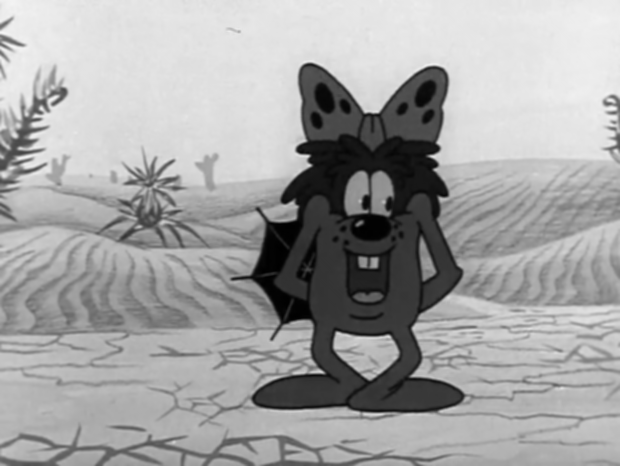

time GPU:  0:00:00.006702


True

In [69]:
print("Исходное изображение")
display(Image.fromarray(np.uint8(img_gray)))

# Cтартовое время
start_time = datetime.datetime.now()

#Копируем данные в текстуру
textur = BilateralGPU.get_texref("tex")
textur.set_filter_mode(pycuda.driver.filter_mode.LINEAR)
textur.set_address_mode(0, pycuda.driver.address_mode.MIRROR)
textur.set_address_mode(1, pycuda.driver.address_mode.MIRROR)
pycuda.driver.matrix_to_texref(img_gray.astype(np.uint32), textur, order="C")

#Запускаем функцию ядра

bilateral_GPU = np.zeros((img_gray.shape[0], img_gray.shape[1]), dtype = np.uint32)

BilateralFilteringGPU(driver.Out(bilateral_GPU), 
       np.int32(M), np.int32(N), 
       np.float32(sigma_сolor),
       np.float32(sigma_space),
       texrefs=[textur], 
       block=(block[0], block[1], 1), 
       grid=grid)

# Затраченное время
time_GPU = datetime.datetime.now() - start_time
print("Полученное изображение")
display(Image.fromarray(np.uint8(bilateral_GPU)))
print ('time GPU:  '+ str(time_GPU))
# Сохраняем
cv2.imwrite('bilateral_GPU.bmp', bilateral_GPU.astype(np.uint8))

In [75]:
print("Время работы на CPU (исходное изображение): ", time_CPU)
print("Время работы на CPU (изображение в градациях серого): ", time_CPU_gray)
print("Время работы на GPU: ", time_GPU)
print("Ускорение (изображения в градациях серого): ", time_CPU_gray/time_GPU)


Время работы на CPU (исходное изображение):  0:00:00.060999
Время работы на CPU (изображение в градациях серого):  0:00:00.056892
Время работы на GPU:  0:00:00.006702
Ускорение (изображения в градациях серого):  8.488809310653536


Из результатов видно, что скорость вычисления на GPU выше, чем на CPU. 